#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
# TAKEAWAY: space derivative depend on nodes granularity. 
# Need increase number of nodes!

In [3]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random

In [4]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [5]:
# from diffeqpy import ode
# from diffeqpy import de

In [6]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [7]:
from sympy import *

In [8]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [9]:
mp = 96 #  (submerged) [kg/m]

In [10]:
# # q0=[i for i in range(12)]
# max_t = 2 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# ds = 0.025
# print(t)

In [11]:
node_N=4

In [12]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [13]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [15]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [16]:
DT=np.diag(diag_DT) # (35) in [2]

In [17]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [18]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
# diag_CT = 1e10*np.array([1, 1, 1]) 

In [19]:
CT=np.diag(diag_CT)

In [20]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [21]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [22]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [23]:
rng = np.random.default_rng()

In [24]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [25]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
#     print(Re_t_(xyz[0]))
    return np.apply_along_axis(Re_t_, 1, xyz)

In [26]:
# φ, θ, ψ= np.zeros(node_N),np.zeros(node_N),np.zeros(node_N)

In [27]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[-0.85947981, -0.36047283, -0.36242765],
       [-0.07327986,  0.78858145, -0.61054841],
       [ 0.50588984, -0.49819538, -0.70418523]])

In [28]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001186


In [29]:
Ret

array([[[-0.85947981, -0.36047283, -0.36242765],
        [-0.07327986,  0.78858145, -0.61054841],
        [ 0.50588984, -0.49819538, -0.70418523]],

       [[ 0.38865477,  0.55094947, -0.73851347],
        [-0.90147359,  0.39310277, -0.18115071],
        [ 0.1905068 ,  0.73615548,  0.64944766]],

       [[ 0.28188383,  0.27344895,  0.91965601],
        [-0.40813453,  0.90165272, -0.14299854],
        [-0.86831314, -0.3350344 ,  0.36576528]],

       [[ 0.30998976, -0.84504151,  0.43567326],
        [ 0.95043315,  0.26379817, -0.16458238],
        [ 0.02414914,  0.46509716,  0.8849302 ]]])

In [30]:
Ret.shape

(4, 3, 3)

In [31]:
# Dphi1, Dphi2, Dphi3 = symbols("Dphi1 Dphi2 Dphi3")
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [32]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([dx**2,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret,B.T)
    return ans.T

In [33]:
dx**2

array([1.42463806, 0.03218019, 2.33178502, 0.35303743])

In [34]:
C1(dx,dy,dz,Ret)

array([[-0.76790671,  0.32068172, -4.1440031 ,  1.92804935],
       [-1.47418026,  0.15965959, -2.19345446, -0.33215189],
       [ 1.29793086,  0.27019829, -2.99971042,  2.94213543]])

In [35]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000207


In [37]:
1/2*d0*qw*np.dot(DT,np.array([0.09,0.12727922, 0.12727922])) 

array([52.6516875 , 74.46073019, 74.46073019])

In [38]:
def fD(dx,dy,dz,DT,Ret):
#     print(dx)
#     print(C1(dx,dy,dz).shape) m2*kg/m3 N/m m2/s2*rad
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret)

array([[ -4407.04269773,   1840.40326501, -23782.57441086,
         11065.1406255 ],
       [ -8460.37051969,    916.2917847 , -12588.30957105,
         -1906.23097578],
       [  7448.86925974,   1550.67718113, -17215.43991244,
         16885.01510086]])

In [40]:
fD(dx,dy,dz,DT,Ret).T

array([[ -4407.04269773,  -8460.37051969,   7448.86925974],
       [  1840.40326501,    916.2917847 ,   1550.67718113],
       [-23782.57441086, -12588.30957105, -17215.43991244],
       [ 11065.1406255 ,  -1906.23097578,  16885.01510086]])

In [41]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000307


In [42]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [43]:
# Mat=np.matrix([[1.3,.4,6.7],[9,7,6],[3.3,5.6,7]])

In [44]:
I=np.identity(3)

In [45]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000227


In [46]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [47]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [48]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [49]:
DR=np.diag(diag_DR) 

In [50]:
dI= 0.69# Inner diameter of pipe, [m]

In [51]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [52]:
Ar

0.08091250419136858

In [53]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [54]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [55]:
from numpy import linalg as LA

In [56]:
def k_sigma(hi,d0,fg_e):
    ans=[]
#     print('hi',hi)
    for it in hi:
#         print(it)
        if it<0:
            ans.append(0)
        elif 0<=it<=d0/20:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
        else:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*hi**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))
#     print(ans)         
     
    return np.array(ans).reshape(node_N,1)   

In [57]:
x,y,z=np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)])

In [58]:
def hi(x,y,z,d0):
    return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [59]:
startTime1 = datetime.now()
hi(x,y,z,d0)
print(datetime.now() - startTime1)

0:00:00.000166


In [60]:
k_sigma(hi(x,y,z,d0),d0,fg_e)

array([[8964.69710988],
       [8964.69710988],
       [8964.69710988],
       [8964.69710988]])

In [61]:
startTime1 = datetime.now()
k_sigma(hi(x,y,z,d0),d0,fg_e)
print(datetime.now() - startTime1)

0:00:00.000750


In [62]:
# TODO: force shoud be acting only at nodes that are in contact with the seabed
def sigma(x,y,z):
    return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [63]:
startTime1 = datetime.now()
sigma(x,y,z)
print(datetime.now() - startTime1)

0:00:00.001200


In [64]:
# # angles should be in radians, otherwise np.radians them  
# def Re_t_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
  
#     Cφ=np.matrix([[1,0,0],
#                       [0,np.cos(φ),-np.sin(φ)],
#                       [0,np.sin(φ),np.cos(φ)]])

#     Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
#                       [0,1,0],
#                       [-np.sin(θ),0,np.cos(θ)]])

#     Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
#                       [np.sin(ψ),np.cos(ψ),0],
#                       [0,0,1]])
        

#     return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [65]:
# Re_t_([1,2,3])

In [66]:
# φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [67]:
# def Re_t(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
# #     print(Re_t_(xyz[0]))
#     return np.apply_along_axis(Re_t_, 1, xyz)

In [68]:
# φ, θ, ψ

In [69]:
# Re_t_(np.array([φ[0], θ[0], ψ[0]]))

In [70]:
# startTime1 = datetime.now()
# Ret=Re_t(φ,θ,ψ)
# print(datetime.now() - startTime1)

In [71]:
# Ret

In [72]:
# vessel motion
# Fossen book p.101, p.190, p.384, p.431
# Fossen paper, section 6

In [73]:
# Fossen paper, equation (12)

In [74]:
# φ,θ,ψ=1,2,3

In [75]:
def Re_b(Ret):
    return np.dot(Ret, Rb_t ) # (5) in[3]

In [76]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000217


In [77]:
# p=np.dot(Re_b, phi) # (41) in[3]

In [78]:
# def d_s(da,db,dc,dt,ds):
    
def d_s(da,db,dc,x,y,z):
#     return np.vstack([da*dt/ds,db*dt/ds,dc*dt/ds])
#     print(np.diff(da))

    ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
                 +np.diff(z,prepend=z[0])**2)
#     print(ds)
    ds[ds == 0] = 1
    return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [79]:
# a=[1,2,3]
# np.diff(a,prepend=a[0])

In [80]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)


In [81]:
startTime1 = datetime.now()
d_s(x,y,z,x,y,z)
print(datetime.now() - startTime1)

0:00:00.001739


In [82]:
# φ,θ,ψ=np.array([2.3 for i in range(node_N)]),np.array([1.3 for i in range(node_N)]),np.array([2.1 for i in range(node_N)])


In [83]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [84]:
def ne(x,y,z,Ret):
#     print(np.multiply(Re_t(φ,θ,ψ),CT).shape)
#     print(np.multiply(np.multiply(Re_t(φ,θ,ψ),CT),
#                          Re_t(φ,θ,ψ)).shape)
#     print(d_s(dx,dy,dz,dt,ds).shape)
    
    A=np.multiply(np.multiply(Ret,CT),Ret)
#     B=d_s(dx,dy,dz,dt,ds).T
    B=d_s(x,y,z,x,y,z).T
    
#     print(A)
    
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)
#     return np.array(ans)

In [85]:
def ne_(x,y,z,dx,dy,dz,Ret):
#     print('ho',fg_e.shape)
#     print(fD(dx,dy,dz,DT))
#     print(sigma(x,y,z))
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T
#     return -fg_e-fD(dx,dy,dz,DT)

In [86]:
sigma(x,y,z)

array([[     0.        ,      0.        , 245278.73527222],
       [     0.        ,      0.        , 796987.90156722],
       [     0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        ]])

In [87]:
ne_(x,y,z,dx,dy,dz,Ret)

array([[  4407.04269773,  -1840.40326501,  23782.57441086,
        -11065.1406255 ],
       [  8460.37051969,   -916.2917847 ,  12588.30957105,
          1906.23097578],
       [ -7577.03380197,  -1678.84172336,  17087.27537021,
        -17013.17964309]])

In [88]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [89]:
startTime1 = datetime.now()
ne(x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000383


In [90]:
startTime1 = datetime.now()
ne_(x,y,z,dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000498


In [91]:
Re_b(Ret).shape

(4, 3, 3)

In [92]:
def Irho_e(Ret):
    return np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 

In [93]:
Irho_e(Ret)

array([[[ 73.87055368,   0.        ,   0.        ],
        [  0.        ,  62.18607047,   0.        ],
        [  0.        ,   0.        ,  99.17536738]],

       [[ 15.10525278,   0.        ,   0.        ],
        [  0.        ,  15.452979  ,   0.        ],
        [  0.        ,   0.        ,  84.35645366]],

       [[  7.94584934,   0.        ,   0.        ],
        [  0.        ,  81.29776239,   0.        ],
        [  0.        ,   0.        ,  26.75684798]],

       [[  9.60936524,   0.        ,   0.        ],
        [  0.        ,   6.95894729,   0.        ],
        [  0.        ,   0.        , 156.62029043]]])

In [94]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000131


In [95]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ)*np.cos(ψ),-np.sin(ψ),0],
#                   [np.cos(θ)*np.sin(ψ),np.cos(ψ),0],
#                   [-np.sin(θ),0,1]])
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [96]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [97]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000545


In [98]:
def ωe(φ,θ,ψ,x,y,z):  # (100) in [2]
    A=Π(φ,θ,ψ)
#     print(A)
#     B=np.array([φ,θ,ψ]).T
    B=d_s(φ,θ,ψ,x,y,z).T
#     print(B)
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)    
#     return np.array(ans) 
#     ans=[]
#     for i in range(len(φ)):
#         ans.append(np.dot(Π(φ[i],θ[i],ψ[i]),np.array([φ[i],θ[i],ψ[i]])))  # (100) in [2]
#     return np.vstack(ans)    

In [99]:
# np.dot(np.matrix([[-0.13504574, -0.86320937,  0.        ],
#   [ 0.23090749, -0.5048461 ,  0.        ],
#   [-0.96355819,  0.,          1.        ]]),np.array([2.3, 1.3, 2.1]))

In [100]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,x,y,z)
print(datetime.now() - startTime1)

0:00:00.001157


In [101]:
diag_CR = 1e11*np.array([1, 1, 1]) 
# diag_CR = 1e7*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [102]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [103]:
def me(φ,θ,ψ,x,y,z,Ret):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=ωe(φ,θ,ψ,x,y,z)
    ans=[]
    return np.einsum('ijk,ik->ij', A,B) 
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
#     return np.array(ans)
#     tmp=[]
#     for i in range(len(φ)):
#         tmp.append(np.dot(np.dot(Re_t(φ[i],θ[i],ψ[i]),CR),Re_t(φ[i],θ[i],ψ[i]).T))
        
#     tmp1= ωe(φ,θ,ψ)
    
#     ans=[]
#     for i in range(len(tmp1)):
#         ans.append(np.dot(np.array(tmp[i]),tmp1[i] ))
#     return np.array(ans).reshape(3,-1)

In [104]:
startTime1 = datetime.now()
me_=me(φ,θ,ψ,x,y,z,Ret)
print(datetime.now() - startTime1)

0:00:00.000990


In [105]:
me_

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.16530917e+07,  1.64264994e+08,  7.83308599e+07],
       [ 4.33959111e+06,  4.30581115e+08, -8.98125300e+05],
       [ 3.66773856e+07, -4.20575609e+07,  8.07401650e+08]])

In [106]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [107]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [108]:
ne_(x,y,z,dx,dy,dz,Ret)

array([[  4407.04269773,  -1840.40326501,  23782.57441086,
        -11065.1406255 ],
       [  8460.37051969,   -916.2917847 ,  12588.30957105,
          1906.23097578],
       [ -7577.03380197,  -1678.84172336,  17087.27537021,
        -17013.17964309]])

In [109]:
C=ne(x,y,z,Ret)
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [110]:
d_s(a,b,c,x,y,z)

array([[       0.        ,   375614.68911357,  -269252.98732767,
          430346.62581532],
       [       0.        ,  -203447.0693726 ,  -630210.81823045,
         1222170.28826576],
       [       0.        ,  1786914.39039713, -1291702.2558498 ,
         2407469.97129224]])

In [111]:
Re_b(Ret).shape

(4, 3, 3)

In [112]:
ne_(x,y,z,dx,dy,dz,Ret).T

array([[  4407.04269773,   8460.37051969,  -7577.03380197],
       [ -1840.40326501,   -916.2917847 ,  -1678.84172336],
       [ 23782.57441086,  12588.30957105,  17087.27537021],
       [-11065.1406255 ,   1906.23097578, -17013.17964309]])

In [113]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([ 170.97462641,  120.07427675,   -0.82265666, -132.44113661]),
 array([ 72.4578533 , 236.25146901, -89.03687111, -18.0849316 ]),
 array([1.19358203, 0.17938838, 1.52701834, 0.59416953]),
 numpy.ndarray,
 array([ 0.21202001, -0.13493549, -2.04371232,  1.86574842]))

In [114]:
ne_(x,y,z,dx,dy,dz,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(x,y,z,dx,dy,dz,Ret).T)

array([[   315.67141925,  19435.26024738,  -4226.83792221],
       [ -1820.66800902,    686.70968247,  -3794.30412213],
       [ 49643.17310381,  11788.64789474,  -1531.03119852],
       [-23518.25263983,  -5307.51558669, -31449.28704273]])

In [115]:
ne_(x,y,z,dx,dy,dz,Ret).T

array([[  4407.04269773,   8460.37051969,  -7577.03380197],
       [ -1840.40326501,   -916.2917847 ,  -1678.84172336],
       [ 23782.57441086,  12588.30957105,  17087.27537021],
       [-11065.1406255 ,   1906.23097578, -17013.17964309]])

### Catenary

In [116]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [117]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [118]:
Fx_0=82945396

In [119]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [120]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [121]:
delta_x=horizontal_length/(node_N-1)

In [122]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [123]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

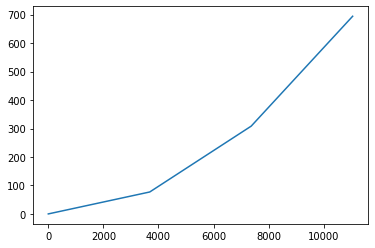

In [124]:
plt.plot(x0, z0)
plt.show()

In [125]:
rng = np.random.default_rng()
q0=np.zeros(12*node_N)

In [126]:

for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
# #     elif j==7 or j==9 or j==11: 
#     elif j==9 or j==11: 
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
# #         q0[(j-1)*node_N:j*node_N]=np.array([0.01 for x in range(node_N)])

In [127]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [128]:
q0[node_N*6]=0

In [129]:
q0[node_N*8]=0

In [130]:
q0[node_N*10]=0

### Vessel

In [131]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

#         self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.G =1.0e10 *np.array([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA
#         print(self.G,self.M)

    def eq_left(self,η, dη):
        φ,θ,ψ=η[3:]
        Ret=Re_t_([φ,θ,ψ])
        A=Re_b(Ret)
        B=np.dot(np.linalg.inv(Π_([φ,θ,ψ])),Re_b(Ret))
        Z=np.zeros((3,3))
        C0=np.concatenate([A,Z],axis=1)
        C1=np.concatenate([Z,B],axis=1)
        C=np.concatenate([C0,C1],axis=0)

        return (np.matmul(self.D, dη) + np.dot(C,self.G))
        
    def tau(self,η, dη, ddη):
        φ,θ,ψ=η[3:]
        Ret=Re_t_([φ,θ,ψ])
        A=Re_b(Ret)
#         print(Π_([φ,θ,ψ]))
#         print(Re_b(Ret))
        B=np.dot(np.linalg.inv(Π_([φ,θ,ψ])),Re_b(Ret))
        Z=np.zeros((3,3))
        C0=np.concatenate([A,Z],axis=1)
        C1=np.concatenate([Z,B],axis=1)
        C=np.concatenate([C0,C1],axis=0)
#         print(np.dot(C,self.G))
#         print(np.matmul(self.M,ddη))
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(C,self.G))
#         return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + self.G)/10000000

In [132]:
V=VesselSemisub()

In [133]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [134]:
tau_force = V.tau(η,dη, ddη)

In [135]:
tau_force

array([ 3.38785484e+06, -2.37412183e+06,  4.34580086e+06, -1.36399445e+10,
        3.02038732e+10,  1.28049082e+10])

In [136]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [137]:
# def tau_wave(z,wave_force):
# #     C=np.exp(z[-1])-np.exp(z[0])
# #     ans=[]
# #     for i in range(len(z)):
# #         ans.append([wave_force/C*(np.exp(z[i])-np.exp(z[0]))])
       
#     return np.array([0,0,wave_force]).T

In [138]:
# tau_wave(z0,wave_force)

In [139]:
wave_force=9e6
kp, kd=1.95e9,1.5e9

In [140]:
# x,y,z,φ,θ,ψ=η
# dx,dy,dz,dφ,dθ,dψ=dη

In [141]:
def Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)

In [142]:
# Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0)

In [143]:
# def tau_t(x, dx, φ, θ, ψ, kp, kd,  x_ref = 0, dx_ref=0):
#     F=
#     Ret=Re_t_([φ,θ,ψ])  
#     return np.dot(Re_b(Ret), F)
    


In [144]:
# tau_t(x, dx, φ, θ, ψ, kp, kd)

In [145]:
η

array([0.1, 0.3, 0.4, 0.5, 0.6, 0.7])

In [146]:
def tau(η, dη, wave_force, kp, kd, x_ref = 0, dx_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
#     print(-Fx(x,dx, kp, kd, x_ref, dx_ref))
    F=(np.array([-Fx(x,dx, kp, kd, x_ref, dx_ref),0,0])+np.array([0,0,wave_force])).T
#     print(F)
    Ret=Re_t_([φ,θ,ψ])
    
    return  np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)

In [147]:
tau(η, dη, wave_force, kp, kd)

array([ 1.28175824e+08,  1.47056830e+08, -7.15869348e+06,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [148]:
# sampleTime = 1e-5                # sample time [seconds]
# N = int(2e5)                         # number of samples

In [149]:
# N

In [150]:
# vehicle_1=semisub('DPcontrol',0.,5.,30.0,0,0) 

In [151]:
# [simTime_1, simData_1] = simulate(N, sampleTime, vehicle_1)

In [152]:
# vehicle_2=semisub('DPcontrol',0.,-5.,30.0,0,0) 

In [153]:
# [simTime_2, simData_2] = simulate(N, sampleTime, vehicle_2)

In [154]:
# simData_1.shape

In [155]:
# simData=np.concatenate([simData_1,simData_2], axis=0)
# simData=simData_1

In [156]:
# simData.shape

In [157]:
# ans_t = simTime_1

In [158]:
# simData[250]

In [159]:
# simData.shape

In [160]:
# ans_t=[]
# sum_=0
# for i in range(simData.shape[0]):
#     ans_t.append(sum_)
#     sum_+=sampleTime

In [161]:
# plotVehicleStates(simTime_1, simData_1, 1)                    
# plotControls(simTime_1, simData_1, vehicle_1, 2)

In [162]:
# plotVehicleStates(simTime_2, simData_2, 1)                    
# plotControls(simTime_2, simData_2, vehicle_2, 2)

In [163]:
# numDataPoints = 5                 # number of 3D data points
# FPS = 10                            # frames per second (animated GIF)
# filename = '3D_animation.gif'       # data file for animated GIF
# browser = 'safari'                  # browser for visualization of animated GIF

In [164]:
# plot3D(simData, numDataPoints, FPS, filename, 3)  

### Modelling

In [165]:
# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return idx

In [166]:
# simData[1]

In [167]:
# simD_1=np.insert(simData_1, 0, simData_1[0], axis=0)
# simD_2=np.insert(simData_2, 0, simData_2[0], axis=0)

In [168]:
# diff_1=np.diff(simD_1,axis=0)
# diff_2=np.diff(simD_2,axis=0)

In [169]:
# diff=np.concatenate([diff_1,diff_2], axis=0)

In [170]:
# diff=diff_1

In [171]:
V=VesselSemisub()

In [172]:
# thres =0.1

In [173]:
# def retrieve_name(var):
#     callers_local_vars = inspect.currentframe().f_back.f_locals.items()
#     return [var_name for var_name, var_val in callers_local_vars if var_val is var]

In [174]:
# simD=np.concatenate([simD_1,simD_2], axis=0)

In [175]:
# simD = simD_1

In [176]:
# SD0=simD[:, 0]
# SD1=simD[:, 1]
# SD2=simD[:, 2]
# SD3=simD[:, 3]
# SD4=simD[:, 4]
# SD5=simD[:, 5]
# SD6=simD[:, 6]
# SD7=simD[:, 7]
# SD8=simD[:, 8]
# SD9=simD[:, 9]
# SD10=simD[:, 10]
# SD11=simD[:, 11]
# Diff6=diff[:, 6]
# Diff7=diff[:, 7]
# Diff8=diff[:, 8]
# Diff9=diff[:, 9]
# Diff10=diff[:, 10]
# Diff11=diff[:, 11]

In [177]:
# def feedback(Q):
#     x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
#     φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

#     K = 2e6 # feedback gain
#     u_x = -K * x 
#     u_y = -K * y
#     u_z = -K * z 
#     u_dx = -K * dx 
#     u_dy = -K * dy 
#     u_dz = -K * dz 
#     u_φ = -K * φ 
#     u_θ = -K * θ
#     u_ψ = -K * ψ 
#     u_dφ= -K * dφ 
#     u_dθ = -K * dθ 
#     u_dψ = -K * dψ 
#     return np.concatenate([u_x, u_dx, u_y, u_dy, u_z, u_dz, u_φ, u_dφ, u_θ, u_dθ, u_ψ, u_dψ], axis=0) 

In [178]:
# def Jv(x, y, z):
    
#     def Jv0(k,x0,x1,y0,y1,z0,z1):
#         tmp1=(x0+x1)/2 
#         tmp2=(y0+y1)/2
#         tmp3=(z0+z1)/2 
#         return np.array([tmp1, tmp2, tmp3]).T 
# #         else:
# #             return np.array([0, 0, 0]).T 
    
#     ans=np.array([Jv0(k, x[k-1],x[k], y[k-1], y[k], z[k-1], z[k]) for k in range(1,node_N)])
    
#     return np.concatenate([ans,np.array([0, 0, 0]).reshape(3,1).T], axis=0).T

In [179]:
# x, y, z = q0[0:node_N],q0[2*node_N:3*node_N],q0[4*node_N:5*node_N]

In [180]:
# q0

In [181]:
# Jv(x, y, z )

In [182]:
# class Time:
#     def __init__(self):
#         self.time=1
# # #         self.n=1
# # # #         self.my_max = sampleTime*N*2
# #         self.my_time=0
# # # #         self.my_n=0
# #         self.my_update=up

In [183]:
# co=Time()

In [184]:
# def asymptote(t):
#     return t/np.sqrt(t**2+1)

In [185]:
from scipy.integrate import solve_ivp

In [186]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
#     Q,t=np.array(Q),np.array(t)
#     print(t)
#     dt=0
#     dt=abs(t-co.time)
#     print('dt',t,co.time,dt)
#     co.time+=sampleTime
  
#     if co.my_time%co.my_max==0:
#         co.my_n+=1
        
#     co.my_time+=co.my_update     
    
#     print(Q)   
#     print(abs(co.my_time))
    
#     idx = find_nearest(ans_t,  co.my_time%len(ans_t)) #!!!!!!!!!!!!!!!!!!!!!
#     print(idx)
#     idx = find_nearest(ans_t,  t%len(ans_t)) 
#     print('idx',idx)
#     print(t)
#     print(idx)
#     ind=ans_t.index(val)
    # State vectors
#     x_ve = SD0[idx]
#     y_ve = SD1[idx]
#     z_ve = SD2[idx]
#     print(x_ve,y_ve,z_ve)
#     phi_ve = R2D(ssa(SD3[idx]))
#     theta_ve = R2D(ssa(SD4[idx]))
#     psi_v = R2D(ssa(SD5[idx]))
#     phi_ve = ssa(SD3[idx])
#     theta_ve = ssa(SD4[idx])
#     psi_v = ssa(SD5[idx])
#     phi_ve = SD3[idx]
#     theta_ve = SD4[idx]
#     psi_v = SD5[idx]
#     u_ve = SD6[idx]
#     v_ve = SD7[idx]
#     w_ve = SD8[idx]
#     p_ve = SD9[idx]
#     q_ve = SD10[idx]
#     r_ve = SD11[idx]
#     p_ve = ssa(SD9[idx])
#     q_ve = ssa(SD10[idx])
#     r_ve = ssa(SD11[idx])
    
    
#     print(t-co.time)
#     du_ve = Diff6[idx]/sampleTime
#     dv_ve = Diff7[idx]/sampleTime
#     dw_ve = Diff8[idx]/sampleTime
#     dp_ve = Diff9[idx]/sampleTime
#     dq_ve = Diff10[idx]/sampleTime
#     dr_ve = Diff11[idx]/sampleTime
#     print(u_ve, dr_ve )
    
#     co.time=t
#     co.n+=1
#     print(co.time)
#     η=np.array([ x_ve, y_ve, z_ve,phi_ve, theta_ve,  psi_v])
#     dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
#     ddη=np.array([du_ve, dv_ve, dw_ve, dp_ve, dq_ve, dr_ve])
#     print( dη)
#     print(ddη)
    
#     tau_force = V.tau(η,dη, ddη)*asymptote(t)
#     tau_force = V.tau(η,dη, ddη)
#     co.time += 1
#     print(tau_force )
#     print()
    
    
    
    
#     p_ve = R2D(simData[:, 9][idx])
#     q_ve = R2D(simData[:, 10][idx])
#     r_ve = R2D(simData[:, 11][idx])

#     if t>dt*co.count:
#         co.count+=1
        
#     print(type(Q))
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     print(x0[-1],y0[-1])

#     x[-1]=x_ve+x0[-1]
#     y[-1]=y_ve
#     z[-1]=z_ve+z0[-1]

#     print( x[-1], y[-1], z[-1])
    x[0]=0
    y[0]=0
    z[0]=0
#     print(z)
#     print(z_ve)
#     print(x_ve,y_ve,z_ve)
#     print(x[0],y[0],z[0])
#     print(x[-1],y[-1],z[-1])
#     print()
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
    dx[0]=0
    dy[0]=0
    dz[0]=0
    
    
#     dx[-1]=u_ve
#     dy[-1]=v_ve 
#     dz[-1]=w_ve
#     print(dx,dy.shape, dx.shape)
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
  
    
    
    
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)
    
#     φ[-1]=phi_ve
#     θ[-1]=theta_ve
#     ψ[-1]=psi_v
    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)
#     print(left.shape)
    ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_force, kp, kd), rcond=None)[0]
 
    tau_force = V.tau(η,dη,ddη)
#     print(tau_force)
#     print(η,dη,ddη)
#     print(tau_force)
    
#     dφ[-1]=p_ve
#     dθ[-1]= q_ve
#     dψ[-1]=r_ve
#     print(z)    
#     print(t)
    
#     ddx = np.empty_like(y)
#     ddy = np.empty_like(y)
#     ddz = np.empty_like(y)
#     ddφ = np.empty_like(y)
#     ddθ = np.empty_like(y)
#     ddψ= np.empty_like(y)
    C=ne(x,y,z,Ret)
#     print('C',C)
  
    a,b,c=C[:,0],C[:,1],C[:,2]
#     print('abc',a,b,c)
#     print(a,C)
#     print(a)
    
#     for it in [φ,θ,ψ,x,y,z,dx,dy,dz]:
#         print(it)
    # here single Re_b(φ,θ,ψ) etc.
#     print(np.einsum('ijk,ik->ij', Re_b(φ,θ,ψ).astype(float), ne_(x,y,z,dx,dy,dz).astype(float).T))
#     print(ne_(x,y,z,dx,dy,dz).astype(float))
#     Z0=np.zeros((node_N,3))
#     print(tau_force[:3].shape)
#     Z0[-1]=tau_force[:3]
#     print(Z0)
#     Z0=np.dot(Jv(x, y, z ).T,tau_force[:3]).reshape(node_N,1)
#     print(Z0)
#     print()
#     Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z0=tau_force[:3]
#     print(Z0)
#     Z0=tau_force[:3].T
#     print(Z0)
    Z1 = d_s(a,b,c,x,y,z).T
#     print(Z1.shape)
#     Z2 =np.einsum('ijk,ik->ij', Re_b(Ret), ne_(x,y,z,dx,dy,dz,Ret).T)
#     print(Z1,Z2)
    Z2=ne_(x,y,z,dx,dy,dz,Ret).T
#     print(Z0)
#     Z=(np.einsum('ijk,ik->ij', Re_b(Ret), Z1 + Z2) 
    Z= ( Z1 + Z2 
        + Z0 
       )
#     print(Z1,Z2, - Z0,Z)
#     print()
#     print(Z0,Z1,Z2)
#     print(Z)
    
    
#     if np.isnan(np.sum(Z0)):
#         print('Z0 NaN',np.isnan(np.sum(Z0)))
#     if max(abs(np.amax(Z0)), abs(np.amin(Z0)))>thres :
#         print('Z0', Z0) 
                  
#     if np.isnan(np.sum(Z1)):
#         print('Z1 NaN',np.isnan(np.sum(Z1)))
#     if max(abs(np.amax(Z1)), abs(np.amin(Z1)))>thres :
#         print('Z1', Z1)    
                  
#     if np.isnan(np.sum(Z2)):
#         print('Z2 NaN',np.isnan(np.sum(Z2)))
#     if max(abs(np.amax(Z2)), abs(np.amin(Z2)))>thres :
#         print('Z2', Z2)      
#     print(Z.shape)
    
#     ddx,ddy, ddz = 1/Ws*torch.linalg.lstsq(torch.from_numpy(Re_b(Ret).astype(np.float64)),torch.from_numpy(Z.astype(np.float64))).solution.cpu().numpy().T
############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
    for i in range(len(RRRR)):
        a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
    
#     print(ddx,ddy, ddz)
#     print(ddx,ddy, ddz)
#     print('ddx',ddx)  
#     print('ddy',ddy) 
#     print('ddz',ddz) 
    
    me_=me(φ,θ,ψ,x,y,z,Ret)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)

    
#     C1=np.einsum('ijk,ik->ij', Re_b(Ret).astype(np.float32), np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
#                                                         np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
#                                                                   np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    
#     print(Re_b(φ,θ,ψ).shape)
# #     print(me_)
# #     print(me_[:,0])
#     print(d_s(me_[:,0],me_[:,1],me_[:,2],dt,ds).shape)
# #     print(Irho_e(φ,θ,ψ).shape)
#     print(d_s(me_[:,0],me_[:,1],me_[:, 2],dt,ds))
#     print(me_)
#     print('d_s',d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z))
#     C3= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T)
    C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
#     C3=np.einsum('ijk,ik->ij', Re_b(Ret),C3_)
#     print(C3.shape)
#     print(d_s(x,y,z,dt,ds).shape)
#     print(ne(x,y,z,φ,θ,ψ,dt,ds).T.shape)
    C4= np.cross(d_s(x,y,z,x,y,z).T,ne(x,y,z,Ret))
#     print(np.dot(DR,K).shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(np.dot(DR,K[:,0]))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T
#     print('K1',np.array([dφ,dθ,dψ]))
#     C5= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),-np.dot(DR,K1).astype(np.float32).T)
    C5= -np.dot(DR,K1).astype(np.float32).T
#     if np.isnan(np.sum(C1)):
#         print('C1',np.isnan(np.sum(C1)))
#     if np.isnan(np.sum(C2)):    
#         print('C2',np.isnan(np.sum(C2)))
#     if np.isnan(np.sum(C3)):    
#         print('C3',np.isnan(np.sum(C3)))
#     if np.isnan(np.sum(C4)):    
#         print('C4',np.isnan(np.sum(C4)))
#     if np.isnan(np.sum(C5)):    
#         print('C5',np.isnan(np.sum(C5)))
#     print(C5.shape)    
#     C0=np.zeros((node_N,3))
#     C0[-1]=tau_force[3:]
#     print(Π(φ,θ,ψ).shape)
#     print(Re_b(Ret).shape)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ)),Re_b(Ret)).shape)
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(tau_force[3:])
#     print(C0.shape)
#     .reshape(node_N,3)
#     print(np.einsum('ijk,ikr->ijr',Π(φ,θ,ψ),Re_b(Ret)).shape)
#     if np.isnan(np.sum(C0)):
#         print('C0',np.isnan(np.sum(C0)))
#     for a in [C1,C2,C3,C4,C5,C0]:   
#         if max(abs(np.amax(a)), abs(np.amin(a)))>thres :
#             print('{}'.format( retrieve_name(a)),a)
    
    B_ =(-C1-C2+C3+C4+C5)
    B=(np.einsum('ijk,ik->ij', Re_b(Ret), B_)
       -C0.squeeze()
      )
#     print(B.shape,C0.squeeze().shape)
#     print(B.shape)
#     print(C0, C0.squeeze())
#     print(B)
#     print(B.shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Π(φ,θ,ψ).shape)
#     A1 =Re_b(Ret).astype(np.float32)
    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
#     print(np.einsum('ijk,ijk->ijk',A1,A2))
#     print('A1',A1)
#     print(A1)
#     print('bu',A1[0])
#     print('hey', np.dot(A1[0],A2[0]))
#     print('op', np.einsum('ijk,ikr->ijr',A1,A2))
#     print(Π(φ,θ,ψ).shape)
#     A=np.einsum('ijk,ikr->ijr',np.einsum('ijk,ikr->ijr',A1,A2),A3)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     print(B,A)    
#     if np.isnan(np.sum(A)):     
#         print('A',np.isnan(np.sum(A)))
      
#     if max(abs(np.amax(A)), abs(np.amin(A)))>thres :
#         print('A', A)   
   

#     if np.isnan(np.sum(B)):     
#         print('B',np.isnan(np.sum(B)))
      
#     if max(abs(np.amax(B)), abs(np.amin(B)))>thres :
#         print('B', B)  
#     print(A)
#     print()
#     print()


#     print(A.shape)
#     print(B.shape)
#     print(np.linalg.solve(A,B) ) 

#     print(A.shape,B.shape)
############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ddφ,ddθ,ddψ = torch.linalg.lstsq(torch.from_numpy(A.astype(np.float64)),torch.from_numpy(B.astype(np.float64))).solution.cpu().numpy().T
    
#     test1 = np.concatenate([ddφ,ddθ,ddψ])
    
#     if np.isnan(np.sum(test1)):     
#         print('test1 NaN',np.isnan(np.sum(test1)))
      
#     if max(abs(np.amax(test1)), abs(np.amin(test1)))>thres :
#         print('test1', test1)
#     torch.from_numpy(A),torch.from_numpy(B))
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    
#     print(ans_ψ)
#     ddφ,ddθ,ddψ =np.linalg.lstsq(A,B,rcond=-1).T 
#     ddφ,ddθ,ddψ =torch.linalg.tensorsolve(torch.from_numpy(A),torch.from_numpy(B)).T
#     print(ddφ)
#     print(np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ]))
    
    # is it the right order ?
#     print('dx',dx)
#     print('dy',dy)
#     print('dz',dz)
    
#     A1111=np.concatenate(np.stack([dx,ddx, dy, ddy, dz, ddz dφ, dθ, dψ, , ddy, ddφ, ddθ, ddψ], axis=0).T) 
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0) 
#     if np.isnan(np.sum(A1111)): 
#         print('A1111 NaN',np.isnan(np.sum(A1111)))
#     if np.amax(A1111)>thres :
#         print('A1111', A1111)  
        
        
#     print(A1111)
#     print(A1111)
    
#     print(A)
#     print()
#     print(A1111)
#     print(A1111)
#     return torch.from_numpy(A1111)

#     return A1111+feedback(Q)
#     print(φ,θ,ψ)
#     print(Ret)
#     if np.isnan(np.sum(φ)):     
#         print('φ',np.isnan(np.sum(φ)))
#     if np.isnan(np.sum(θ)):     
#         print('θ',np.isnan(np.sum(θ)))
#     if np.isnan(np.sum(ψ)):     
#         print('ψ',np.isnan(np.sum(ψ))) 
#     print(A1111)
    return A1111

In [187]:
# q0[7*node_N:8*node_N],q0[9*node_N:10*node_N],q0[11*node_N:12*node_N]

In [188]:
# for i in range(1000):
#     Q1111=100*rng.standard_normal(12*node_N)
#     print(grayscott1d(Q1111, 0.1, simData))

In [189]:
# q0.shape

In [190]:
# import numpy as np

In [191]:
# np.concatenate([np.array([0,3,6]),np.array([1,4,7]),np.array([2,5,8])], axis=0)

In [192]:
# # q0=[i for i in range(12)]
# max_t =2 #0.1 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# # ds = 0.025
# print(t)

In [193]:
# grayscott1d(4,q0)

In [194]:
# grayscott1d(4,q0).shape

In [195]:
# # q0=[i for i in range(12)]
# max_t = 2 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# ds = 0.025
# print(t)

In [196]:
import scipy

In [197]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [198]:
tspan = (0., 2)

In [199]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [200]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, method='BDF'
#              ,rtol=1, atol=1
            )
# us=ode15s.integrate(3)
print(datetime.now() - startTime1)

0:19:52.247145


In [201]:
# co.my_time

In [202]:
fin=us

In [203]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [204]:
fin

  message: 'Required step size is less than spacing between numbers.'
     nfev: 48015
     njev: 4110
      nlu: 14633
      sol: None
   status: -1
  success: False
        t: array([0.00000000e+00, 5.35158166e-14, 1.07031633e-13, ...,
       6.46862483e-03, 6.46862483e-03, 6.46862483e-03])
 t_events: None
        y: array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.68422828e+03, 3.68422828e+03, 3.68422828e+03, ...,
        5.46950098e+03, 5.46950098e+03, 5.46950098e+03],
       [7.36845656e+03, 7.36845656e+03, 7.36845656e+03, ...,
        9.15372926e+03, 9.15372926e+03, 9.15372926e+03],
       ...,
       [0.00000000e+00, 3.83479351e-15, 7.66964993e-15, ...,
        9.40470734e-03, 9.40471584e-03, 9.40471825e-03],
       [0.00000000e+00, 3.83479351e-15, 7.66964993e-15, ...,
        9.40470739e-03, 9.40471589e-03, 9.40471830e-03],
       [0.00000000e+00, 3.83479351e-15, 7.66964993e-15, ...,
        9.404707

In [205]:
# !pip3 install diffeqpy

In [206]:
# node_N

In [207]:
# t

In [208]:
# plt.plot(us.t,us.u)
# plt.show()

In [209]:
# node_N

In [210]:
# Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

In [211]:
# fin

In [212]:
# import odespy, numpy
# solver = odespy.Vode(f, rtol=0.0, atol=1e-6,
#                      adams_or_bdf='adams', order=10)
# solver.set_initial_condition([2.0, 0.0])
# t_points = numpy.linspace(0, 30, 150)
# u, t = solver.solve(t_points)

In [213]:
fin.y.T[0]

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


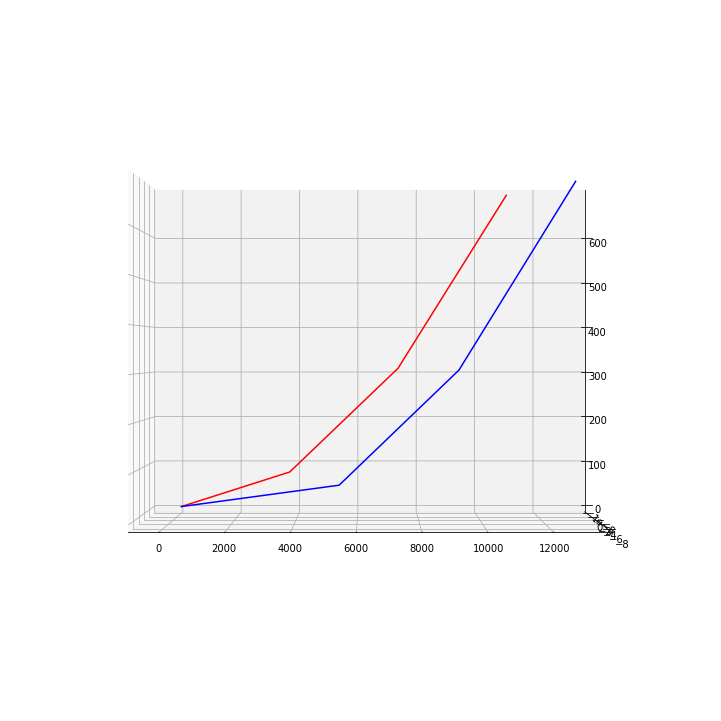

In [227]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin.y.T[0,[i for i in range(0,node_N)]]
Y0=fin.y.T[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin.y.T[0,[i for i in range(4*node_N,5*node_N)]]
X=fin.y.T[-1,[i for i in range(0,node_N)]]
Y=fin.y.T[-1,[i for i in range(2*node_N,3*node_N)]]
Z=fin.y.T[-1,[i for i in range(4*node_N,5*node_N)]]
# X0=x0
# Y0=[0 for i in range(node_N)]
# Z0=z0
# X=[fin[i] for i in range(0,node_N)]
# Y=[fin[i] for i in range(2*node_N,3*node_N)]
# Z=[fin[i] for i in range(4*node_N,5*node_N)]
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
ax.view_init(0,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [228]:
X,Y,Z

(array([    0.        ,  5469.50097883,  9153.72925986, 12837.95754135]),
 array([ 0.00000000e+00, -9.03084787e-08, -8.73174039e-08, -7.50546046e-08]),
 array([  0.        ,  77.21699805, 308.55642848, 694.57153374]))

In [216]:
X0,Y0,Z0

(array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446]),
 array([0., 0., 0., 0.]),
 array([  0.        ,  77.06804645, 308.4070593 , 694.42189511]))

In [217]:
# E = 210e9

In [218]:
# E*Ar

In [219]:
# 1e10

In [220]:
# import torch

In [221]:
# A = torch.randn(20,3,3)
# B = torch.randn(20,3)
# X = torch.linalg.lstsq(A, B).solution # A is broadcasted to shape (2, 3, 3)


In [222]:
# X

In [223]:
# type(A)

In [224]:
# X.shape

In [225]:
# plot3D(fin, numDataPoints, FPS, filename, 3)